# Helpfulness Classification

#### Table of Contents
1. [Data Preparation](#1.-Data-Preparation)
   1. [Load Dataset](#1.1-Loading-the-Helpful-Sentences-from-Reviews-Dataset)
   2. [Pre-processing](#1.2-Pre-processing-the-data)
2. [Model Training](#2.-Model-Training)
   1. [Set up](#2.1-Set-up)
   2. [Fine-tuning BERT Model](#22-fine-tuning-bert-model)
   3. [Ensemble Learning](#2.3-Ensemble-Learning-Bagging-Algorithm)
3. [Experiments](#3.-Experiments)
   1. [Set up](#3.1-Set-up)
   2. [The overall performance of the model](#32-the-overall-performance-of-the-model)
   3. [Experiments - Convert the task to classification problem](#33-experiments---convert-the-task-to-classification-problem)

In [2]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error, classification_report
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)


from datasets import load_dataset


device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else ("xpu" if torch.xpu.is_available() else "cpu"))
 
print(device)

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'add_model_info_to_custom_pipelines' from 'transformers.utils' (/Users/jim181412/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/transformers/utils/__init__.py)

## 1. Data Preparation

### 1.1 Loading the "Helpful Sentences from Reviews" Dataset

In [2]:
# Path of dataset
data_files = {"train": "./data/train.json", "test": "./data/test.json"}

# Load dataset
dataset = load_dataset("json", data_files=data_files["test"], split='train')\
          .remove_columns(["asin", "main_image_url"])


# Split into train and test data -> 80% : 20%
split_dataset = dataset.train_test_split(train_size=0.8, seed=42) # Shuffled by default
split_dataset

Found cached dataset json (/local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
Loading cached split indices for dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-507c488b89086b5a.arrow and /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-8f3a243ad04e0776.arrow


DatasetDict({
    train: Dataset({
        features: ['sentence', 'helpful', 'product_title'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['sentence', 'helpful', 'product_title'],
        num_rows: 400
    })
})

### 1.2 Pre-processing the data

#### 1.2.1 Setup

In [3]:
model_ckpt = "distilbert-base-uncased"

kwargs = {
    "num_labels": 1,
    "activation": "sigmoid",
}

bert_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, **kwargs)
bert_model = bert_model.to(device)  # Send the model to GPU if available

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, **kwargs)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

#### 1.2.2 Define the pre-processing functions

In [4]:
def normalize_labels(row):
    # Set the key name to 'labels' for the Trainer
    row["labels"] = row["helpful"]
    return row

def tokenization(row):
    return tokenizer(
        row["sentence"], 
        truncation=True, 
        padding="max_length", 
        max_length=70   # The 'max_length' is chosen after experiments (which can be found in section 2.1)
    )

#### 1.2.3 Pre-process the data

In [5]:
tokenized_dataset = split_dataset.map(normalize_labels).map(tokenization, batched=True)

tokenized_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

tokenized_dataset

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'helpful', 'product_title', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['sentence', 'helpful', 'product_title', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
})

#### 1.2.4 Experiment: Find the most appropriate max_length for padding of tokenizer

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-fcde925611f7c0cd.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-2e89713688ee1beb.arrow


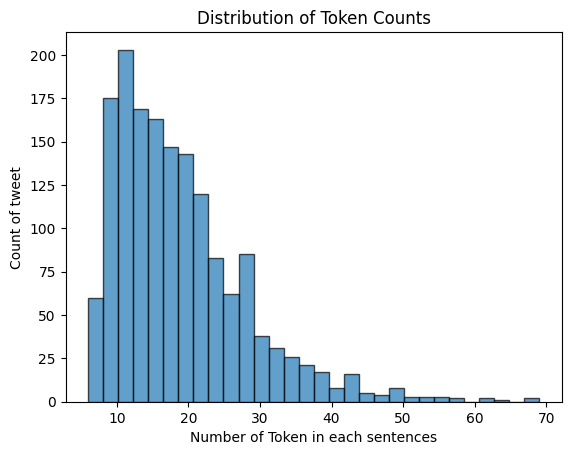

The max number of tokens in the dataset: 69


In [6]:
# Calculate the length of tokens in tokenized reviews
# (to help determine the max_length for padding)
trial_dataset = split_dataset.map(
    lambda row: tokenizer(row["sentence"]), 
    batched=True
)

input_token_length = np.array(
    [len(input_ids) for input_ids in trial_dataset['train']["input_ids"]], 
    # dtype=torch.float
)

plt.hist(input_token_length, bins=30, edgecolor='k', alpha=0.7)
plt.gca().set(
    title='Distribution of Token Counts', 
    xlabel='Number of Token in each sentences',
    ylabel='Count of tweet'
)

plt.show()

print(f"The max number of tokens in the dataset: {np.max(input_token_length)}")

## 2. Model Training

### 2.1 Set up

#### 2.1.1 Define Metrics

In [7]:
# Method for Computing Accuracy
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

#### 2.1.2 Set up the training arguments

In [8]:
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=15,
    learning_rate=3e-5,  # Default: 5e-05
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy= "steps",    # 'epoch', 'steps'
    eval_steps=100,
    logging_steps=100,
    logging_strategy= "steps",
    # gradient_accumulation_steps=8,
    metric_for_best_model="eval_mse",
    load_best_model_at_end=True,
)

early_stop = EarlyStoppingCallback(
    early_stopping_patience=3, 
    early_stopping_threshold=0.001
)

### 2.2 Fine-tuning BERT Model

#### 2.2.1 Training starts here

In [9]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics_for_regression,
    callbacks=[early_stop]
)

trainer.train()
trainer.save_model("/local/home/p11333at/nlu/standard_model")

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
  Number of trainable parameters = 66954241


Step,Training Loss,Validation Loss


#### 2.2.2 Evaluate the model

In [10]:
res = trainer.predict(tokenized_dataset["test"])
single_model_predictions = res.predictions.squeeze()
single_model_metrics = res.metrics
print(f''' ------ Metrics Evaluation ------
Mean Squared Error:         {single_model_metrics['test_mse']:.3f}
Root Mean Squared Error:    {single_model_metrics['test_rmse']:.3f}
Mean Absolute Error:        {single_model_metrics['test_mae']:.3f}
R2 Score:                   {single_model_metrics['test_r2']:.3f}
''')

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 400
  Batch size = 16


 ------ Metrics Evaluation ------
Mean Squared Error:         0.061
Root Mean Squared Error:    0.248
Mean Absolute Error:        0.192
R2 Score:                   0.601



### 2.3  Ensemble Learning (Bagging Algorithm)


#### 2.3.1 Set up

In [11]:
ensemble_size = 20
ensemble_checkpoint_path = '/local/home/p11333at/nlu/ensemble/'

#### 2.3.2 Train the ensemble models

In [12]:
evaluation_list = []

metric_list = []
prediction_list = []
for i in range(ensemble_size):
    print(f"\033[1;34;47m    ==========  {i+1}/{ensemble_size} of ensemble  ==========    \033[0m")

    
    # Initialise bootstrap sample index
    dataset_size = len(tokenized_dataset["train"])
    np.random.seed(42+i)
    bootstrap_index = np.random.choice(dataset_size, dataset_size, replace=True)

    # Retrieve the bootstrap sample
    sample_dataset = tokenized_dataset["train"].select(bootstrap_index)

    print(f"Dataset size: {dataset_size}")
    print(f"Number of distinct data in Bootstrap sample: {len(set(bootstrap_index))}")

    # Instantiate the Model
    bert_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, **kwargs)
    bert_model = bert_model.to(device)  # Send the model to GPU if available

    trainer = Trainer(
        model=bert_model,
        args=training_args,
        train_dataset=sample_dataset,
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics_for_regression,
        callbacks=[early_stop]
    )
    
    trainer.train()

    # Emsemble prediction
    eval_result = trainer.predict(tokenized_dataset["test"])
    evaluation_list.append(eval_result)

    metric_list.append(eval_result.metrics)
    prediction_list.append(eval_result.predictions)

    # Save the model checkpoint
    bert_model.save_pretrained(ensemble_checkpoint_path+f"member_{i+1:02d}")

    # Relsase GPU memory
    del bert_model, trainer
    torch.cuda.empty_cache()


# Ensemble prediction
prediction_list = np.array(prediction_list)
metrics_list = np.array(metric_list)


loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin


    ==========  1/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 997


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_01/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_01/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  2/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1014


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_02/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_02/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  3/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1012


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_03/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_03/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  4/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1019


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, produc

Configuration saved in /local/home/p11333at/nlu/ensemble/member_04/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_04/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  5/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1008


Configuration saved in /local/home/p11333at/nlu/ensemble/member_05/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_05/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  6/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1016


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_07/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_07/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  8/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1030


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have 

Configuration saved in /local/home/p11333at/nlu/ensemble/member_08/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_08/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  9/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1038


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_09/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_09/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  10/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1015


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_10/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_10/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  11/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1010


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_11/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_11/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  12/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1010


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_12/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_12/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  13/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1022


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, helpful, product_title. If sentence, helpful, product_title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
Saving model checkpoint to ./output/checkpoint-500
Configuration saved in ./output/checkpoint-500/config.json
Model weights saved in ./output/checkpoint-500

Configuration saved in /local/home/p11333at/nlu/ensemble/member_13/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_13/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  14/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 997


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_17/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_17/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  18/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1004


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_18/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_18/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pyt

    ==========  19/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1021


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_19/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_19/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json


    ==========  20/20 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1011


Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/ensemble/member_20/config.json
Model weights saved in /local/home/p11333at/nlu/ensemble/member_20/pytorch_model.bin


#### 2.3.3 Combine the predictions of different models as an ensemble prediction

In [13]:
true = tokenized_dataset["test"]["labels"].cpu().numpy()

# Calculate the prediction of ensembles with different size
ensemble_prediction_list = []
for i in range(ensemble_size):
    ensemble_predictions = np.mean(prediction_list[:i+1], axis=0).squeeze()
    ensemble_prediction_list.append(ensemble_predictions)
ensemble_prediction_list = np.array(ensemble_prediction_list)

# Collect the metrics for each ensemble member
ensemble_metric_dict = {"mse": [], "rmse": [], "mae": [], "r2": []}
for pred in ensemble_prediction_list:
    single_metric = compute_metrics_for_regression((pred, true))
    for key in ensemble_metric_dict:
        ensemble_metric_dict[key].append(single_metric[key])

#### 2.3.4 Evaluate the ensemble model

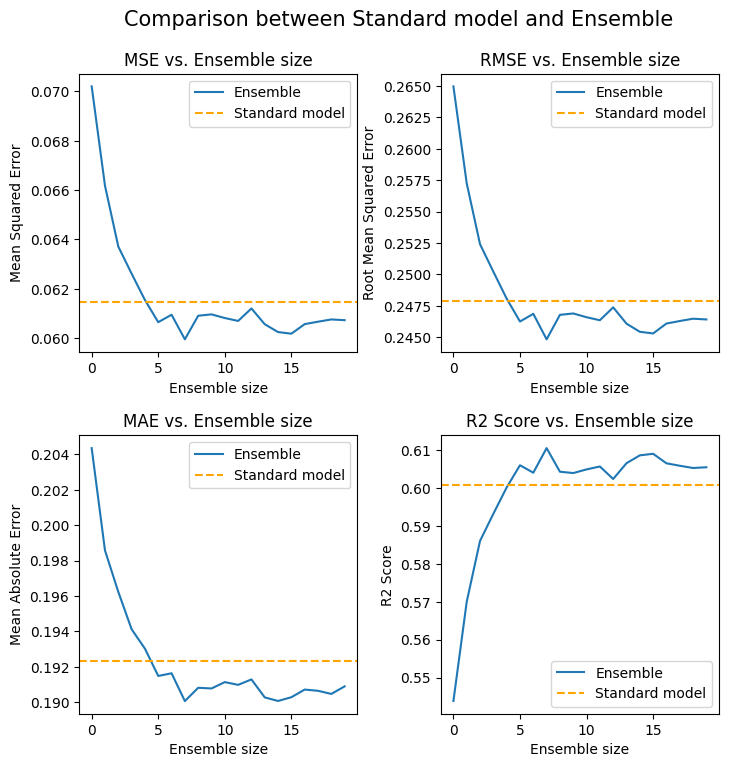

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(np.arange(ensemble_size), ensemble_metric_dict["mse"], label='Ensemble')
axs[0, 0].axhline(y=single_model_metrics["test_mse"], color='orange', linestyle='--', label='Standard model')
axs[0, 0].set_xlabel('Ensemble size')
axs[0, 0].set_ylabel('Mean Squared Error')
axs[0, 0].set_title('MSE vs. Ensemble size')
axs[0, 0].legend()


axs[0, 1].plot(np.arange(ensemble_size), ensemble_metric_dict["rmse"], label='Ensemble')
axs[0, 1].axhline(y=single_model_metrics["test_rmse"], color='orange', linestyle='--', label='Standard model')
axs[0, 1].set_xlabel('Ensemble size')
axs[0, 1].set_ylabel('Root Mean Squared Error')
axs[0, 1].set_title('RMSE vs. Ensemble size')
axs[0, 1].legend()


axs[1, 0].plot(np.arange(ensemble_size), ensemble_metric_dict["mae"], label='Ensemble')
axs[1, 0].axhline(y=single_model_metrics["test_mae"], color='orange', linestyle='--', label='Standard model')
axs[1, 0].set_xlabel('Ensemble size')
axs[1, 0].set_ylabel('Mean Absolute Error')
axs[1, 0].set_title('MAE vs. Ensemble size')
axs[1, 0].legend()


axs[1, 1].plot(np.arange(ensemble_size), ensemble_metric_dict["r2"], label='Ensemble')
axs[1, 1].axhline(y=single_model_metrics["test_r2"], color='orange', linestyle='--', label='Standard model')
axs[1, 1].set_xlabel('Ensemble size')
axs[1, 1].set_ylabel('R2 Score')
axs[1, 1].set_title('R2 Score vs. Ensemble size')
axs[1, 1].legend()


plt.suptitle('Comparison between Standard model and Ensemble', fontsize=15)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# Show the figure
plt.show()

## 3. Experiments

### 3.1  Set up



In [15]:
true = tokenized_dataset['test']['labels'].cpu().numpy()    # Extract true labels (Detach from GPU as well)

######### Uncomment ONLY one of the following lines #########
pred_s = single_model_predictions  # For standard model
pred_e = ensemble_prediction_list[-1]   # For ensemble model
#############################################################

### 3.2 The overall performance of the model

#### 3.2.1 Evaluation graph - for standard model

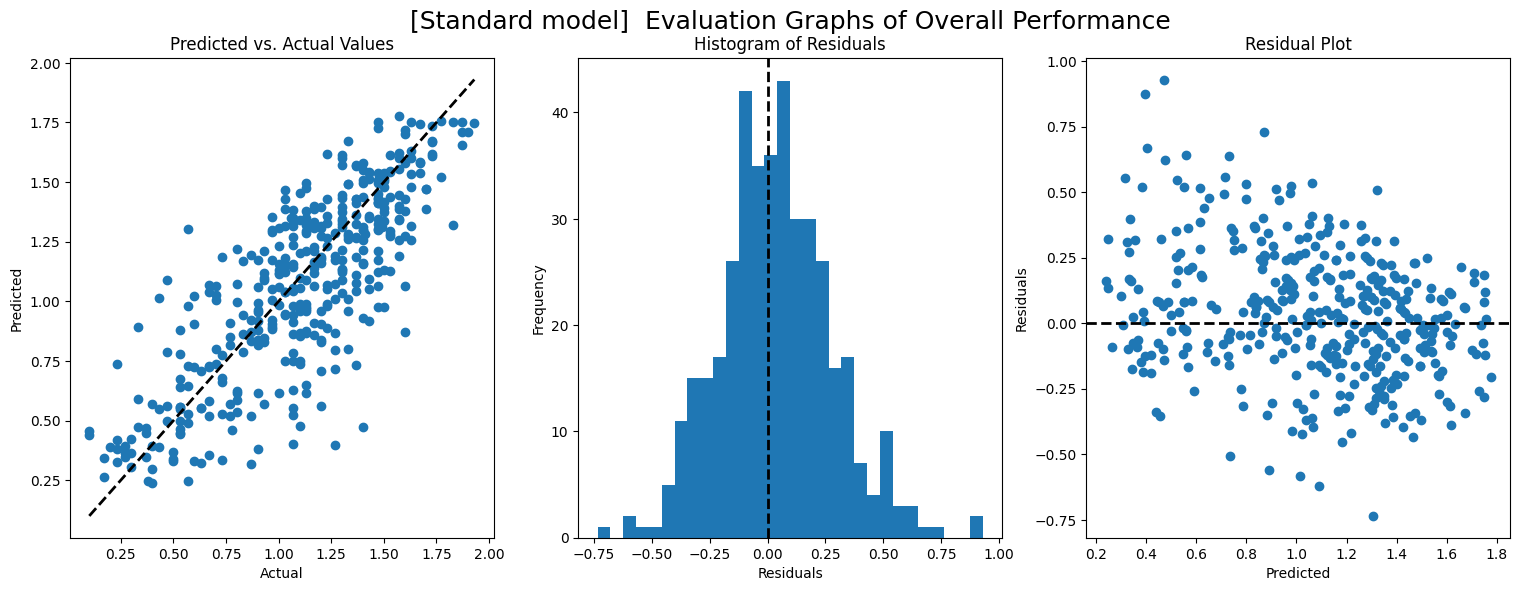

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(true, pred_s)
axs[0].plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Predicted vs. Actual Values')


residuals = true - pred_s
axs[1].hist(residuals, bins=30)
axs[1].axvline(x=0, color='k', linestyle='--', lw=2)
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Residuals')


axs[2].scatter(pred_s, residuals)
axs[2].axhline(y=0, color='k', linestyle='--', lw=2)
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Residual Plot')

fig.suptitle('[Standard model]  Evaluation Graphs of Overall Performance', fontsize=18)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

#### 3.2.2 Evaluation graph - for ensemble model

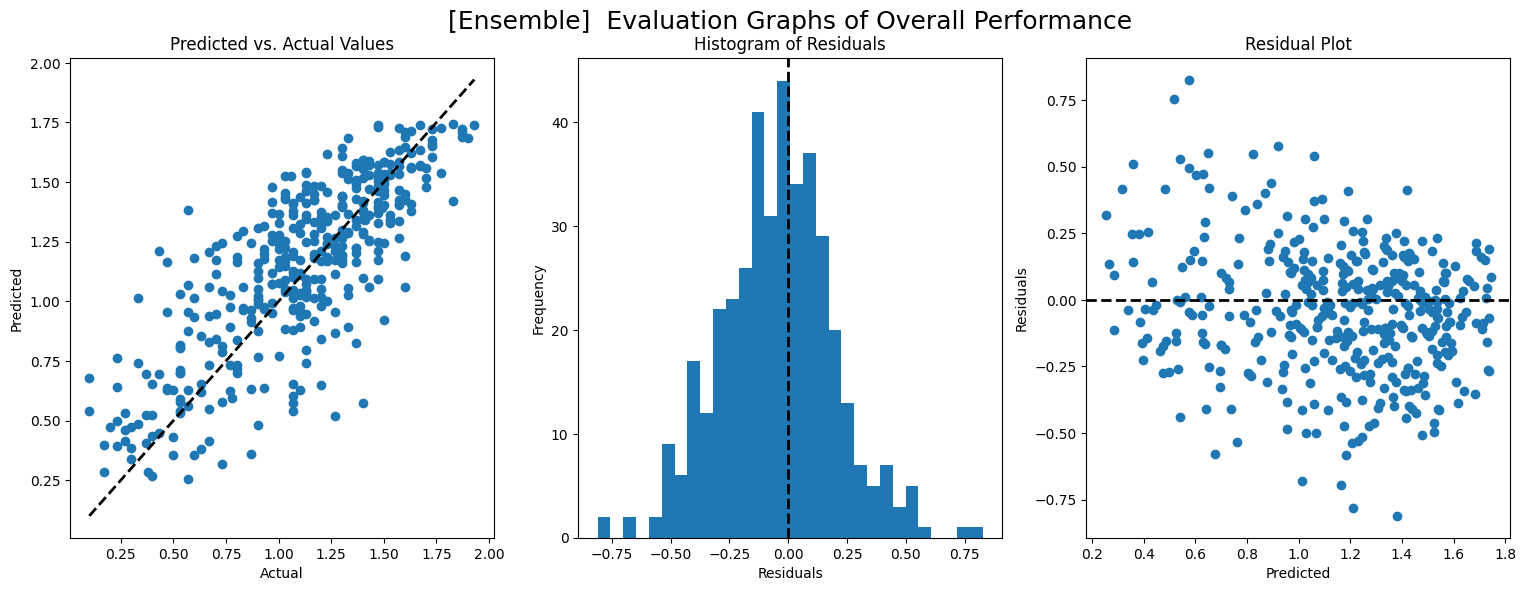

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(true, pred_e)
axs[0].plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Predicted vs. Actual Values')


residuals = true - pred_e
axs[1].hist(residuals, bins=30)
axs[1].axvline(x=0, color='k', linestyle='--', lw=2)
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Residuals')


axs[2].scatter(pred_e, residuals)
axs[2].axhline(y=0, color='k', linestyle='--', lw=2)
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Residual Plot')

fig.suptitle('[Ensemble]  Evaluation Graphs of Overall Performance', fontsize=18)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

### 3.3 Experiments - Convert the task to classification problem

#### 3.3.1 Two classes classification
    Classify a review as:
        1. Helpful
        2. Not Helpful


In [23]:
# 0-1 | 1-2
def convert_value_to_2_labels(true, pred):
    bins = [0, 1, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred_s = convert_value_to_2_labels(true, pred_s)

lable_true, label_pred_e = convert_value_to_2_labels(true, pred_e)

print("\n======= Classification Report for ( 2 ) Labels =======")
print("------------------- Standard Model -------------------")
print(classification_report(lable_true, label_pred_s, target_names=["Not Helpful", "Helpful"]))

print("\n---------------------- Ensemble ----------------------")
print(classification_report(lable_true, label_pred_e, target_names=["Not Helpful", "Helpful"]))
print("======================================================")
print("Overall accuracy is improved by 2% using ensemble model")
print("======================================================")


======= Classification Report for ( 2 ) Labels =======
------------------- Standard Model -------------------
              precision    recall  f1-score   support

 Not Helpful       0.66      0.80      0.72       132
     Helpful       0.89      0.79      0.84       268

    accuracy                           0.80       400
   macro avg       0.77      0.80      0.78       400
weighted avg       0.81      0.80      0.80       400


---------------------- Ensemble ----------------------
              precision    recall  f1-score   support

 Not Helpful       0.76      0.68      0.72       132
     Helpful       0.85      0.90      0.87       268

    accuracy                           0.82       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.82      0.82      0.82       400

Overall accuracy is improved by 2% using ensemble model


#### 3.3.2 Three classes classification
    Classify a review as:
        1. "Not Helpful"
        2. "Slightly Helpful"
        3. "Very Helpful"

In [24]:
# 0-0.66 | 0.66-1.33 | 1.33-2
def convert_value_to_3_labels(true, pred):
    bins = [0, 0.66, 1.33, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred_s = convert_value_to_3_labels(true, pred_s)

lable_true, label_pred_e = convert_value_to_3_labels(true, pred_e)

print("\n======= Classification Report for ( 3 ) Labels =======")
print("------------------- Standard Model -------------------")
print(classification_report(lable_true, label_pred_s, target_names=["Not Helpful", "Slightly Helpful", "Very Helpful"]))

print("\n---------------------- Ensemble ----------------------")
print(classification_report(lable_true, label_pred_e, target_names=["Not Helpful", "Slightly Helpful", "Very Helpful"]))
print("======================================================")
print("Overall accuracy is improved by 2% using ensemble model")
print("======================================================")


======= Classification Report for ( 3 ) Labels =======
------------------- Standard Model -------------------
                  precision    recall  f1-score   support

     Not Helpful       0.62      0.76      0.68        62
Slightly Helpful       0.70      0.72      0.71       206
    Very Helpful       0.74      0.62      0.67       132

        accuracy                           0.69       400
       macro avg       0.69      0.70      0.69       400
    weighted avg       0.70      0.69      0.69       400


---------------------- Ensemble ----------------------
                  precision    recall  f1-score   support

     Not Helpful       0.68      0.61      0.64        62
Slightly Helpful       0.74      0.70      0.72       206
    Very Helpful       0.69      0.78      0.73       132

        accuracy                           0.71       400
       macro avg       0.70      0.70      0.70       400
    weighted avg       0.71      0.71      0.71       400

Overall accurac

#### 3.3.3 Four classes classification 
    Classify a review as:
        1. "Not Helpful"
        2. "Slightly Helpful"
        3. "Helpful"
        4. "Very Helpful"

In [25]:
# 0-0.5 | 0.5-1.0 | 1.0-1.5 | 1.5-2
def convert_value_to_4_labels(true, pred):
    bins = [0, 0.5, 1, 1.5, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred_s = convert_value_to_4_labels(true, pred_s)

lable_true, label_pred_e = convert_value_to_4_labels(true, pred_e)

print("\n======= Classification Report for ( 4 ) Labels =======")
print("------------------- Standard Model -------------------")
print(classification_report(lable_true, label_pred_s, target_names=["Not Helpful", "Slightly Helpful", "Helpful", "Very Helpful"]))

print("\n---------------------- Ensemble ----------------------")
print(classification_report(lable_true, label_pred_e, target_names=["Not Helpful", "Slightly Helpful", "Helpful", "Very Helpful"]))
print("======================================================")
print("Overall accuracy is improved by 2% using ensemble model")
print("======================================================")


======= Classification Report for ( 4 ) Labels =======
------------------- Standard Model -------------------
                  precision    recall  f1-score   support

     Not Helpful       0.55      0.73      0.62        33
Slightly Helpful       0.50      0.60      0.55        99
         Helpful       0.71      0.66      0.68       203
    Very Helpful       0.67      0.52      0.59        65

        accuracy                           0.62       400
       macro avg       0.61      0.63      0.61       400
    weighted avg       0.64      0.62      0.63       400


---------------------- Ensemble ----------------------
                  precision    recall  f1-score   support

     Not Helpful       0.64      0.48      0.55        33
Slightly Helpful       0.55      0.52      0.53        99
         Helpful       0.69      0.72      0.71       203
    Very Helpful       0.58      0.62      0.60        65

        accuracy                           0.64       400
       macro avg